# **NOTEBOOK PLS**

Al momento potresti cominciare in modo semplice con il segnale BOLD provando la seguente cosa per uno dei film (poi puoi andare per tutti i 14):
- **X = Nsubjs x N_brain_features** =  Matrice contenente per ogni soggetto  il vettore di upper triangular values dei connettomi di ciascun soggetti <br>
/media/miplab-nas2/Data2/Movies_Emo/Flavia_E3/Data/TC_114*)
- **Y = Nsubjs x N_behavioural_features** = Matrice contenente per ogni soggetto i behaviour  <br>
/media/miplab-nas2/Data2/Movies_Emo/BIDS/TheRealfMRIStudy/rawdata/participants.tsv <br>


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from PLSC_code.compute import *

Read the data

In [59]:
PATH_DATA = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/'
Y = pd.read_csv(PATH_DATA + 'participants.tsv', sep='\t', header=0)[['DASS_dep', 'DASS_anx',	'DASS_str',	'bas_d', 'bas_f', 'bas_r', 'bis', 'BIG5_ext', 'BIG5_agr', 'BIG5_con', 'BIG5_neu', 'BIG5_ope']]
print('The shape of the Y behavioural dataset is: ', Y.shape, '\nROWS: n of subjects         COLUMNS: n of behavioural variables')

The shape of the Y behavioural dataset is:  (30, 12) 
ROWS: n of subjects         COLUMNS: n of behavioural variables


In [60]:
path_subjects = '/Users/silviaromanato/Desktop/SEMESTER_PROJECT/HigherOrder/Data/DATA_TC/'

list_subjects = []
for i in glob.glob(path_subjects+'*'):
    if (i.split('/')[-1].split('-')[0] == 'TC_114_sub') & (i.split('/')[-1].split('-')[1].endswith('Sintel.txt')):
        list_subjects.append(i)

print('The number of subjects is: ', len(list_subjects))

mtx_upper_triangular = []
for i, PATH_SUBJ in enumerate(list_subjects):
    data_feature = pd.read_csv(PATH_SUBJ, sep=' ', header=None)

    # Obtain the connectivity matrix
    connectivity_matrix = np.corrcoef(data_feature, rowvar=False)

    # Obtain the upper triangular part of the matrix
    upper_triangular = connectivity_matrix[np.triu_indices_from(connectivity_matrix, k=1)]

    # Append the upper triangular part of the matrix to the list
    mtx_upper_triangular.append(upper_triangular)

# Convert the list into a numpy array
mtx_upper_triangular = np.array(mtx_upper_triangular)

X = pd.DataFrame(mtx_upper_triangular)

The number of subjects is:  30


We nwo created the X and Y matrices. It's now time to compute the PLSC behavioural algorithm. <br>

**PLS** is a multivariate method that finds linear combinations of the two matrices that are maximally correlated. <br>
The algorithm is as follows: <br>

0. Normalize and centre the data: **X_n = X - mean(X)** and **Y_n = Y - mean(Y)** 
1. Compute the covariance matrix between X and Y: **R_beh_n = YT_beh_n • X_n**
2. Compute the SVD of R_beh_n: **R_beh_n = U_beh_n • S_beh_n • V_beh_nT**
3. From the saliences **U_beh_n** and **V_beh_nT** compute the latent variables **LV_beh_n = U_beh_n • S_beh_n** and **LV_brain_n = V_beh_nT • S_beh_n**
4. Use PCA to reduce the dimensionality of the latent variables **LV_beh_n** and **LV_brain_n**


In [68]:
# 0. Normalize and centre the data
X = (X - X.mean()) / X.std()
Y = (Y - Y.mean()) / Y.std()

# 1. Compute the correlation between the X and Y
R = R_cov(X, Y)

In [79]:
# 2. Compute the SVD of the data
U, S, V = SVD(R)

# 3. Compute the latent variables from the saliences U and V
T = PLS_scores(X, Y, U, V)
print('The shape of the Lx "brain scores": ', T[0].shape)
print('The shape of the Lx "behavioural scores": ', T[1].shape)

The shape of the Lx "brain scores":  (30, 12)
The shape of the Lx "behavioural scores":  (30, 12)


The shape of the Lx "brain scores" after PCA:  (30, 2)
The explained variance ratio of the first two components:  0.6570437832580702
The shape of the Ly "behavioural scores" after PCA:  (30, 2)
The explained variance ratio of the first two components:  0.51946765230492


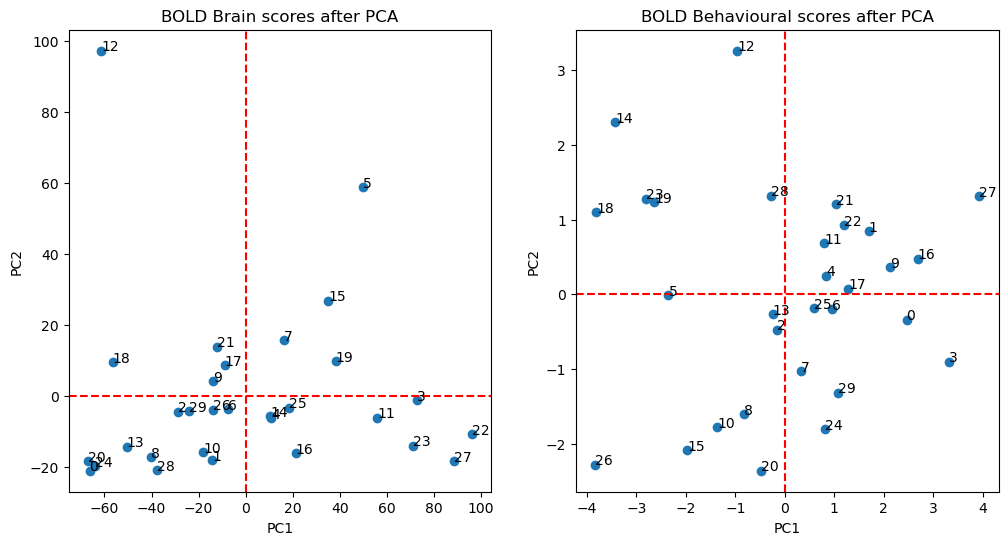

In [114]:
# 4. Use pca to display the scores
from sklearn.decomposition import PCA

# PCA on the brain scores
pca_brain = PCA(n_components=2)
pca_brain.fit(T[0])
T_brain = pca_brain.transform(T[0])
print('The shape of the Lx "brain scores" after PCA: ', T_brain.shape)
print('The explained variance ratio of the first two components: ', pca_brain.explained_variance_ratio_.sum())

# PCA on the behavioural scores
pca_behav = PCA(n_components=2)
pca_behav.fit(T[1])
T_behav = pca_behav.transform(T[1])
print('The shape of the Ly "behavioural scores" after PCA: ', T_behav.shape)
print('The explained variance ratio of the first two components: ', pca_behav.explained_variance_ratio_.sum())

# Visualize the scores after PCA
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(T_brain[:, 0], T_brain[:, 1])
plt.title('BOLD Brain scores after PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axvline(x=0, color='red', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')

for i, txt in enumerate(X.columns):
    if i == 30:
        break
    plt.annotate(txt, (T_brain[i, 0], T_brain[i, 1]))

plt.subplot(1, 2, 2)
plt.scatter(T_behav[:, 0], T_behav[:, 1])
plt.title('BOLD Behavioural scores after PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.axvline(x=0, color='red', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')
# add the label to the number with the index
for j, txt in enumerate(X.columns):
    if j == 30:
        break
    plt.annotate(txt, (T_behav[j, 0], T_behav[j, 1]))

plt.show()

The following representation show the decomposition of the brain score (**Lx**) and the behavioural scores (**Ly**) into 2 principal components. <br>

The algorithm divides therefore  the participants